In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re

from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import scale, minmax_scale
from scipy.stats import norm
from sklearn.utils.validation import check_array
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/nba/'
os.chdir(PATH)

## Read in

In [5]:
train = pd.read_csv(f'{PATH}/dataset/train.csv')
# test = pd.read_csv(f'{PATH}/dataset/holdout.csv')

train.head()

,Engagements,Followers at Posting,Created,Type,Description,date,time,tz,date_tsfmYear,date_tsfmMonth,date_tsfmWeek,date_tsfmDay,date_tsfmDayofweek,date_tsfmDayofyear,date_tsfmIs_month_end,date_tsfmIs_month_start,date_tsfmIs_quarter_end,date_tsfmIs_quarter_start,date_tsfmIs_year_end,date_tsfmIs_year_start,date_tsfmElapsed,time_split,hour,minute,Type_Album,Type_Photo,Type_Video,num_hashes,num_at_signs,num_punct,num_tokens,num_upper,clean_des
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,2019-05-21,23:30:51,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2330,23,30,0,0,1,0,4,1,15,2,The raptors bench trio of sergeibaka normanpow...
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,2019-05-21,22:53:33,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2253,22,50,0,0,1,0,2,2,12,3,kylelowry7 pulls from deep for the raptors in ...
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,2019-05-21,22:19:58,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2219,22,20,0,0,1,0,2,2,8,0,kmid22 with some english on the bucks dime
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,2019-05-21,22:02:41,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2202,22,0,0,0,1,0,0,1,9,4,Kawhi punches it home with the left on TNT
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,2019-05-21,20:47:49,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2047,20,50,0,0,1,0,1,2,10,3,giannisan34 goes baseline early to rock the ri...


In [6]:
train.isna().sum()

Engagements                   0
Followers at Posting          0
Created                       0
Type                          0
Description                  14
date                          0
time                          0
tz                            0
date_tsfmYear                 0
date_tsfmMonth                0
date_tsfmWeek                 0
date_tsfmDay                  0
date_tsfmDayofweek            0
date_tsfmDayofyear            0
date_tsfmIs_month_end         0
date_tsfmIs_month_start       0
date_tsfmIs_quarter_end       0
date_tsfmIs_quarter_start     0
date_tsfmIs_year_end          0
date_tsfmIs_year_start        0
date_tsfmElapsed              0
time_split                    0
hour                          0
minute                        0
Type_Album                    0
Type_Photo                    0
Type_Video                    0
num_hashes                    0
num_at_signs                  0
num_punct                     0
num_tokens                    0
num_uppe

In [0]:
train.fillna('', inplace=True)

In [0]:
# len(train), len(test)

In [0]:
tfidf = TfidfVectorizer(analyzer='word',
                     ngram_range=(1,2),
                     min_df=3,
                     max_df=0.05,
                     stop_words='english')

tfidf_matrix = tfidf.fit_transform(train['clean_des'])

vocab = tfidf.get_feature_names()

In [10]:
tfidf_matrix.shape

(7766, 4391)

## Dimensionality reduction
Reduce dimension of TF-IDF matrix from (7,766, 4,391) to (7,766, 100).

In [0]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)
smaller_d_matrix = svd.fit_transform(tfidf_matrix)

## Feature selection

In [12]:
train.head()

,Engagements,Followers at Posting,Created,Type,Description,date,time,tz,date_tsfmYear,date_tsfmMonth,date_tsfmWeek,date_tsfmDay,date_tsfmDayofweek,date_tsfmDayofyear,date_tsfmIs_month_end,date_tsfmIs_month_start,date_tsfmIs_quarter_end,date_tsfmIs_quarter_start,date_tsfmIs_year_end,date_tsfmIs_year_start,date_tsfmElapsed,time_split,hour,minute,Type_Album,Type_Photo,Type_Video,num_hashes,num_at_signs,num_punct,num_tokens,num_upper,clean_des
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,2019-05-21,23:30:51,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2330,23,30,0,0,1,0,4,1,15,2,The raptors bench trio of sergeibaka normanpow...
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,2019-05-21,22:53:33,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2253,22,50,0,0,1,0,2,2,12,3,kylelowry7 pulls from deep for the raptors in ...
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,2019-05-21,22:19:58,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2219,22,20,0,0,1,0,2,2,8,0,kmid22 with some english on the bucks dime
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,2019-05-21,22:02:41,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2202,22,0,0,0,1,0,0,1,9,4,Kawhi punches it home with the left on TNT
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,2019-05-21,20:47:49,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2047,20,50,0,0,1,0,1,2,10,3,giannisan34 goes baseline early to rock the ri...


There are a few labels we can try out:

*   `Engagement`
*   `Engagement/Followers at Posting`
*   `log(Engagement)`



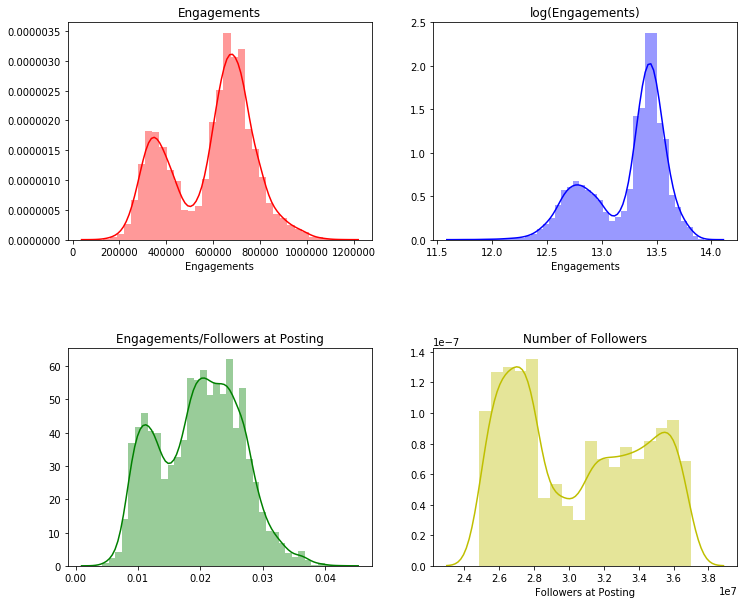

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.distplot(train['Engagements'], 
             ax=axes[0][0], 
             color='r').\
                set_title('Engagements')

sns.distplot(np.log(train['Engagements']), 
             ax=axes[0][1], 
             color='b').\
                set_title('log(Engagements)')

sns.distplot(train['Engagements']/train['Followers at Posting'],
             ax=axes[1][0], 
             color='g').\
                set_title('Engagements/Followers at Posting')

sns.distplot(train['Followers at Posting'], 
             ax=axes[1][1], 
             color='y').\
                set_title('Number of Followers')

plt.subplots_adjust(hspace=0.5)

plt.show()

In [15]:
y = ['Engagements']

exclude = ['Created', 'Type', 'Description', 'date',
           'time', 'tz', 'clean_des']

cols = [c for c in train.columns if c not in y and c not in exclude]

len(cols)

# train[cols].head()

25

In [0]:
X_tr = np.concatenate([train[cols].values, smaller_d_matrix], axis=1)

# X_tr = train['Followers at Posting'].values.reshape(-1, 1)

y_tr = train['Engagements']

## Metric

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def xgb_mape(y_true, dtrain):
    labels = dtrain.get_label()
    return 'mape', np.mean(np.abs((y_true - labels) / y_true)) * 100

## Model

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_mae = []
feature_importance_df = pd.DataFrame()

oof = train[['Engagements']].copy()
oof['predict'] = 0
oof = oof.reset_index(drop=True)

In [0]:
xgb_params = {'objective': 'reg:squarederror',
              'colsample_bytree': 0.3, 
              'learning_rate': 0.1,
              'max_depth': 5, 
              'alpha': 10,}

In [49]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(X_tr, y_tr)):
    X_train, y_train = X_tr[trn_idx], y_tr[trn_idx]
    X_valid, y_valid = X_tr[val_idx], y_tr[val_idx]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_valid, label=y_valid)
        
    xgb_clf = xgb.train(xgb_params,
                        dtrain,
                        5000,
                        evals=[(dtrain, 'train'), (dtest, 'valid')],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        feval=xgb_mape)

    p_valid = xgb_clf.predict(dtest,
                              ntree_limit=xgb_clf.best_ntree_limit)

    oof['predict'][val_idx] = p_valid
    val_score = mean_absolute_percentage_error(y_valid, p_valid)
    val_mae.append(val_score)

[0]	train-rmse:561040	valid-rmse:562294	train-mape:903.219	valid-mape:904.147
Multiple eval metrics have been passed: 'valid-mape' will be used for early stopping.

Will train until valid-mape hasn't improved in 100 rounds.
[100]	train-rmse:40712.9	valid-rmse:55094.4	train-mape:4.70597	valid-mape:6.71325
[200]	train-rmse:29838.3	valid-rmse:52349.6	train-mape:3.43825	valid-mape:6.25659
[300]	train-rmse:23714.2	valid-rmse:51651.2	train-mape:2.75272	valid-mape:6.13966
[400]	train-rmse:19319.4	valid-rmse:51520.1	train-mape:2.25351	valid-mape:6.08563
Stopping. Best iteration:
[390]	train-rmse:19774.3	valid-rmse:51517.5	train-mape:2.29701	valid-mape:6.08091

[0]	train-rmse:561250	valid-rmse:561297	train-mape:903.819	valid-mape:913.929
Multiple eval metrics have been passed: 'valid-mape' will be used for early stopping.

Will train until valid-mape hasn't improved in 100 rounds.
[100]	train-rmse:40407	valid-rmse:57702.5	train-mape:4.68385	valid-mape:6.83104
[200]	train-rmse:30202.4	valid-rmse

In [50]:
mean_mae = np.mean(val_mae)
std_mae = np.std(val_mae)
all_mae = mean_absolute_percentage_error(oof['Engagements'], oof['predict'])
print("Mean mae: %.2f, std: %.2f. All mae: %.2f." % (mean_mae, std_mae, all_mae))

Mean mae: 6.19, std: 0.19. All mae: 6.19.
